In [ ]:
# %pip install numpy tifffile matplotlib scipy

In [1]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt

# **Multi-Pixel Data Extraction to 1D Calcium Trace**  

In this unit, we focus on a common task in calcium imaging: converting multi-pixel fluorescence data from a single neuron into a single 1D trace over time. While each image frame may contain dozens or hundreds of pixels representing a cell, our goal is to summarize this data into a trace that reflects the neuron’s activity. This is a foundational step in calcium imaging analysis, and sets the stage for event detection, deconvolution, and time-series modeling. The sections below walk through each step—starting from pixel selection and ending with signal aggregation using both simple and robust methods.

## **Identifying Active Pixels Using Thresholding**  

To generate a meaningful 1D trace from an image, the first step is to determine which pixels represent the cell’s signal. This involves thresholding fluorescence values to distinguish cell-related activity from background noise. Even in a single-cell image, signal intensity may vary due to inhomogeneous dye uptake, photobleaching, or imaging artifacts. Thresholding helps isolate the most relevant parts of the cell, so that analysis is based on pixels that contribute meaningful information. 

A common first step in working with calcium imaging data is to reduce the 3D data (time × height × width) into a single 2D image. This projection summarizes activity across the entire session, helping us decide which parts of the image are relevant for further analysis. We begin by loading the actual calcium imaging data from a .tif file. This image contains 2000 frames of a single neuron. Our goal here is to reduce the 3D data (time × height × width) to a single image (height x width) that summarizes cell activity across time.

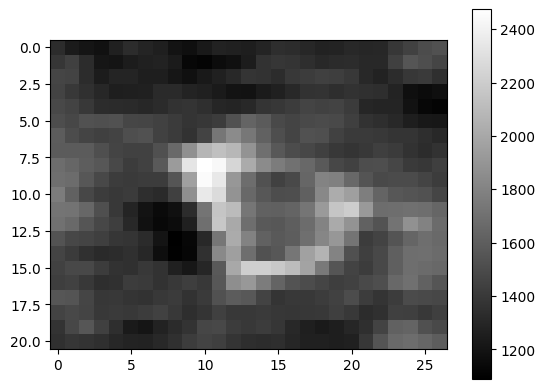

In [2]:
data = tifffile.imread('data/single_cell.tif')
mean_projection = np.mean(data, axis=0)
plt.imshow(mean_projection, cmap='gray')
plt.colorbar()

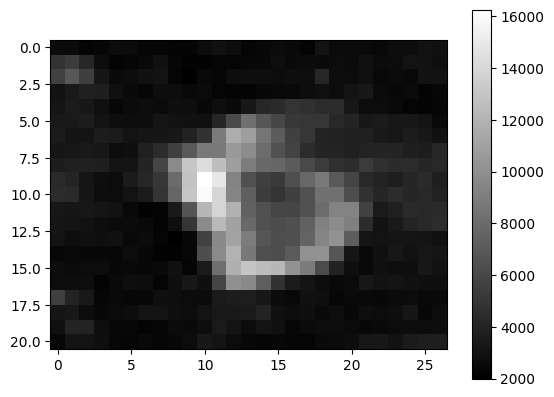

In [3]:
data = tifffile.imread('data/single_cell.tif')
max_projection = np.max(data, axis=0)
plt.imshow(max_projection, cmap='gray')
plt.colorbar()

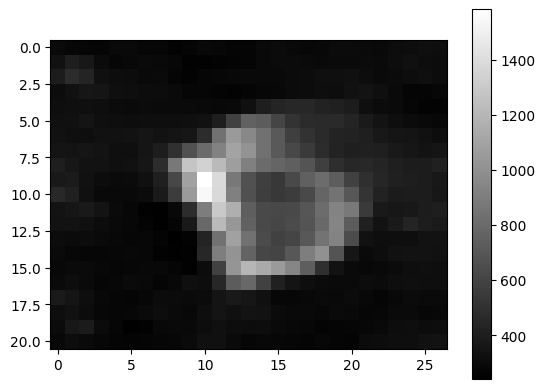

In [4]:
data = tifffile.imread('data/single_cell.tif')
std_projection = np.std(data, axis=0)
plt.imshow(std_projection, cmap='gray')
plt.colorbar()

Once we have a projection, the next step is to isolate regions of interest by applying a global threshold. This defines which pixels are considered "active" or "signal-rich" and will be included in downstream processing.

**Example** Select active pixels by `threshold > 1000`.

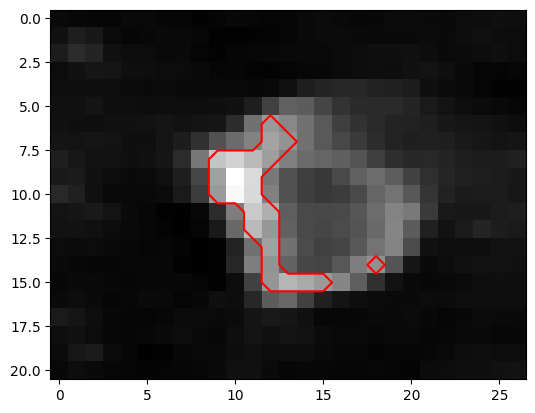

In [8]:
std_projection = np.std(data, axis=0)
mask_abs = std_projection > 1000
plt.imshow(std_projection, cmap='gray')
plt.contour(mask_abs, colors='red')

Select active pixels by `threshold > 100`.

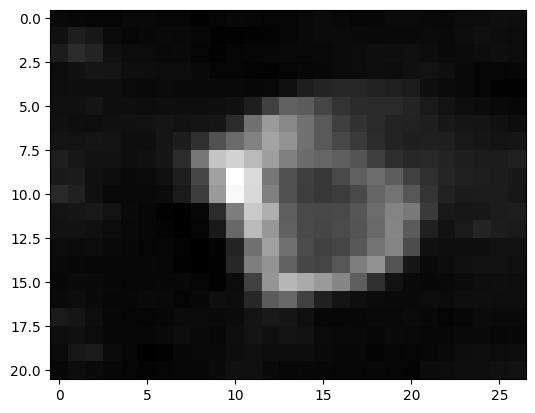

In [9]:
std_projection = np.std(data, axis=0)
mask_abs = std_projection > 100
plt.imshow(std_projection, cmap='gray')
plt.contour(mask_abs, colors='red')

Select active pixels by `threshold > 700`.

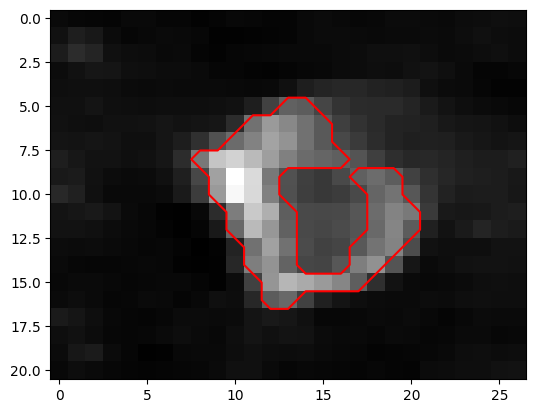

In [10]:
std_projection = np.std(data, axis=0)
mask_abs = std_projection > 700
plt.imshow(std_projection, cmap='gray')
plt.contour(mask_abs, colors='red')

Select active pixels by `threshold > 500`.

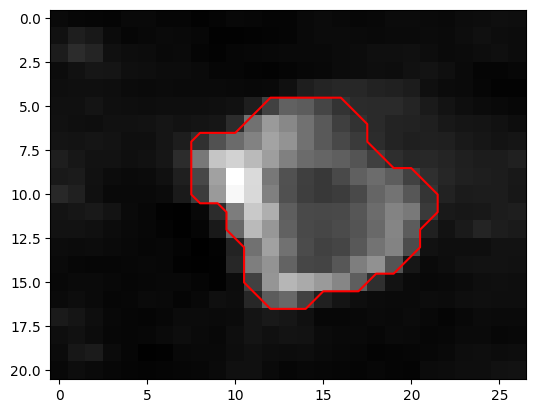

In [11]:
std_projection = np.std(data, axis=0)
mask_abs = std_projection > 500
plt.imshow(std_projection, cmap='gray')
plt.contour(mask_abs, colors='red')

We can also use percentile-based threshold instead of manually assigning a value. This can be used for automated thresholding.

**Example** Apply threshold of 95-percentile.

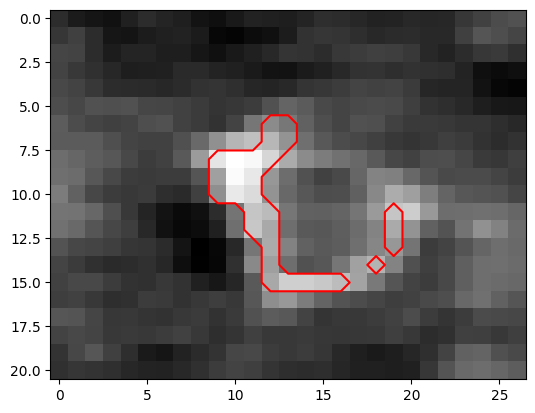

In [12]:
threshold_val = np.percentile(std_projection, 95)
mask_percentile = std_projection > threshold_val
plt.imshow(mean_projection, cmap='gray')
plt.contour(mask_percentile, colors='red')

Apply threshold of 70-percentile.

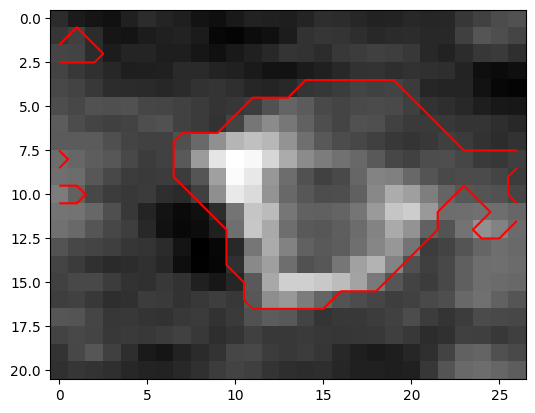

In [13]:
threshold_val = np.percentile(std_projection, 70)
mask_percentile = std_projection > threshold_val
plt.imshow(mean_projection, cmap='gray')
plt.contour(mask_percentile, colors='red')

Apply threshold of 80-percentile.

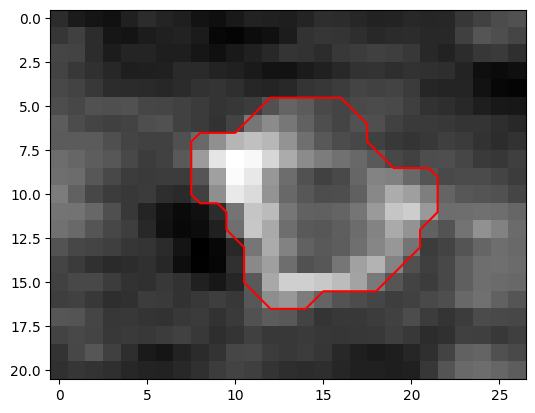

In [14]:
threshold_val = np.percentile(std_projection, 80)
mask_percentile = std_projection > threshold_val
plt.imshow(mean_projection, cmap='gray')
plt.contour(mask_percentile, colors='red')

## **Extracting Pixel Time Series Using Fancy Indexing**  

Once the active pixels have been identified, the next step is to extract their fluorescence values across all time frames. Since cells often have irregular shapes, their pixels are not arranged in a rectangular block. This requires the use of advanced indexing techniques to selectively access those pixel values. In this section, we demonstrate how to use `numpy`'s fancy indexing to extract pixel-wise time series from a 3D calcium imaging dataset. The result is a 2D matrix where each row corresponds to a pixel and each column to a time point.

The steps often involved in extracting time series of pixel intensities are

- Creat binary mask.
- Organize X, Y positions of active pixels into (x,y) pairs (coordinates)
- Create a matrix that holds time series of pixel intensities of all the pairs (n_active_pixels x num_frames)

**Example** How many active pixels for the below mask?

In [15]:
mask = std_projection > 500

In [18]:
y_pixels, x_pixels = np.where(mask)
len(y_pixels)

112

How many active pixels for the below mask?

In [19]:
mask = std_projection > 100

In [20]:
y_pixels, x_pixels = np.where(mask)
len(y_pixels)

567

How many active pixels for the below mask?

In [21]:
threshold_val = np.percentile(std_projection, 80)
mask = std_projection > threshold_val

In [22]:
y_pixels, x_pixels = np.where(mask)
len(y_pixels)

114

**Example** Show the active pixels on the image for the below mask.

In [25]:
mask = std_projection > 500

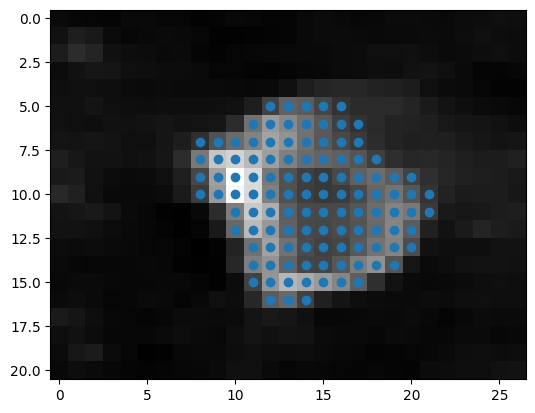

In [26]:
y_pixels, x_pixels = np.where(mask)
plt.imshow(std_projection, cmap='gray')
plt.scatter(x_pixels, y_pixels)

Show the active pixels on the image for the below mask.

In [27]:
mask = std_projection > 100

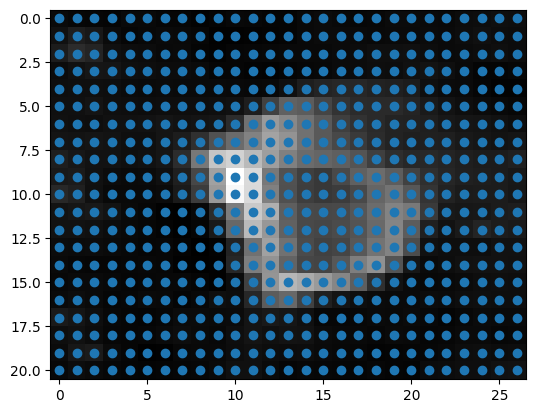

In [28]:
y_pixels, x_pixels = np.where(mask)
plt.imshow(std_projection, cmap='gray')
plt.scatter(x_pixels, y_pixels)

Show the active pixels on the image for the below mask.

In [29]:
threshold_val = np.percentile(std_projection, 80)
mask = std_projection > threshold_val

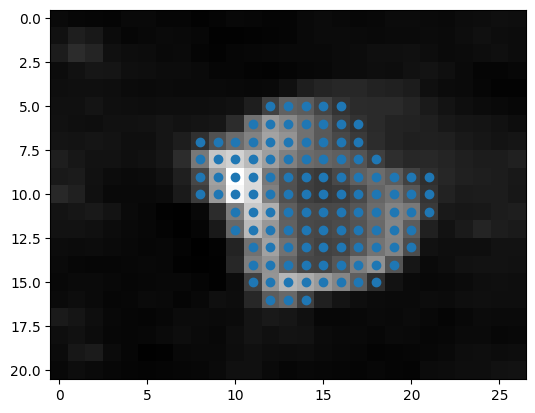

In [30]:
y_pixels, x_pixels = np.where(mask)
plt.imshow(std_projection, cmap='gray')
plt.scatter(x_pixels, y_pixels)

**Example** Extract fluorescence values of first active pixel.

In [35]:
threshold_val = np.percentile(std_projection, 80)
mask = std_projection > threshold_val
y_pixels, x_pixels = np.where(mask)

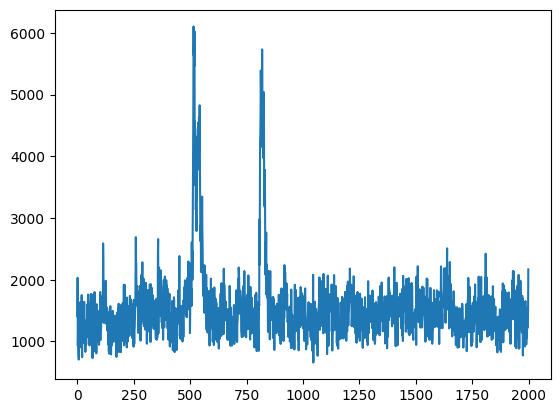

In [32]:
plt.plot(data[:, y_pixels[0], x_pixels[0]])

Extract fluorescence values of tenth active pixel.

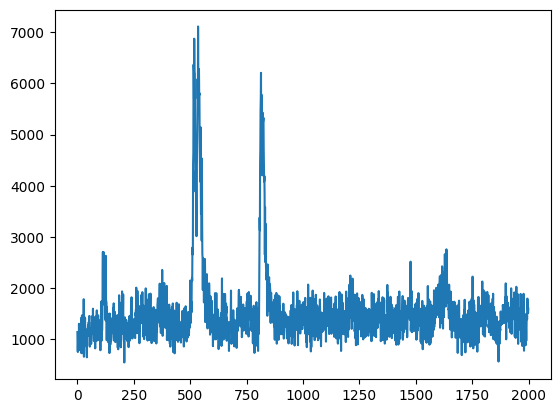

In [33]:
plt.plot(data[:, y_pixels[9], x_pixels[9]])

Extract fluorescence values of last active pixel.

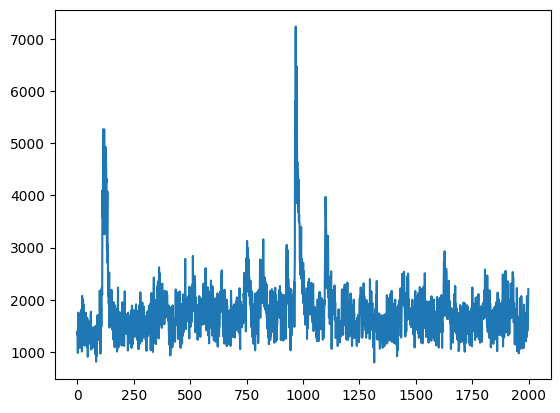

In [34]:
plt.plot(data[:, y_pixels[-1], x_pixels[-1]])

We can create `traces` which is a matrix of (`n_active pixels x num_frames`)

**Example** Create `traces1` combining flourescence values from all pixels defined in the below mask.

In [36]:
mask = std_projection > 100
y_pixels, x_pixels = np.where(mask)

In [37]:
traces1 = data[:, y_pixels, x_pixels]
traces1.shape

(2000, 567)

Create `traces2` combining flourescence values from all pixels defined in the below mask.

In [38]:
mask = std_projection > 500
y_pixels, x_pixels = np.where(mask)

In [39]:
traces2 = data[:, y_pixels, x_pixels]
traces2.shape

(2000, 112)

Create `traces3` combining flourescence values from all pixels defined in the below mask.

In [40]:
threshold_val = np.percentile(std_projection, 80)
mask = std_projection > threshold_val
y_pixels, x_pixels = np.where(mask)

In [41]:
traces3 = data[:, y_pixels, x_pixels]
traces3.shape

(2000, 114)

## **Averaging Pixel Values to Create a 1D Trace**  

With the pixel-wise fluorescence time series in hand, we now reduce this information to a single trace that summarizes the cell's activity. This is commonly done by averaging the fluorescence across all pixels in the ROI at each time point. This section shows how to compute and visualize a mean trace using `numpy`, and also discusses when it might be preferable to use the median instead of the mean. The goal is to obtain a 1D time series that is representative, interpretable, and suitable for downstream analyses.

**Example** Plot mean cell activity from `trace1`.

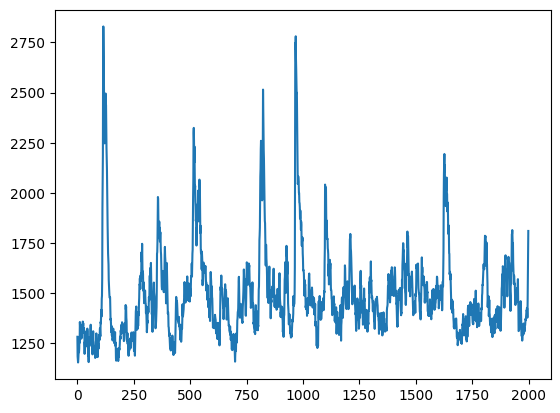

In [45]:
mean_trace = np.mean(traces1, axis=1)
plt.plot(mean_trace)

Plot mean cell activity from `trace2`.

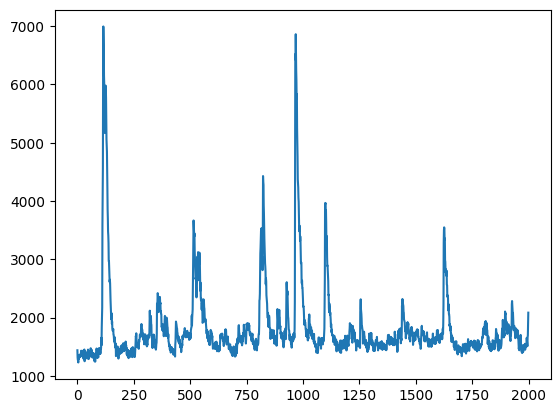

In [46]:
mean_trace = np.mean(traces2, axis=1)
plt.plot(mean_trace)

Plot mean cell activity from `trace3`.

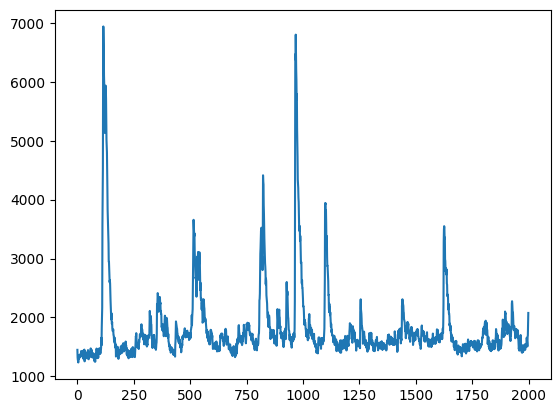

In [47]:
mean_trace = np.mean(traces3, axis=1)
plt.plot(mean_trace)

Plot median cell activity from `trace1`.

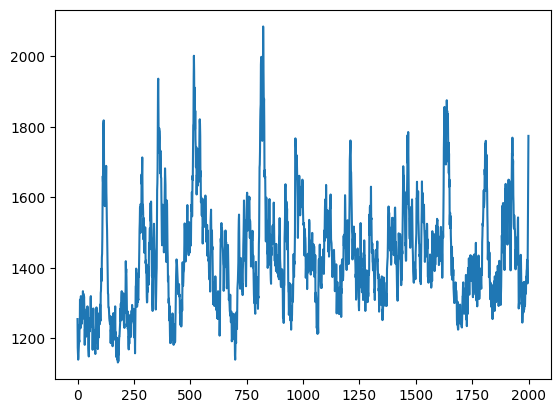

In [48]:
median_trace = np.median(traces1, axis=1)
plt.plot(median_trace)

Plot median cell activity from `trace2`.

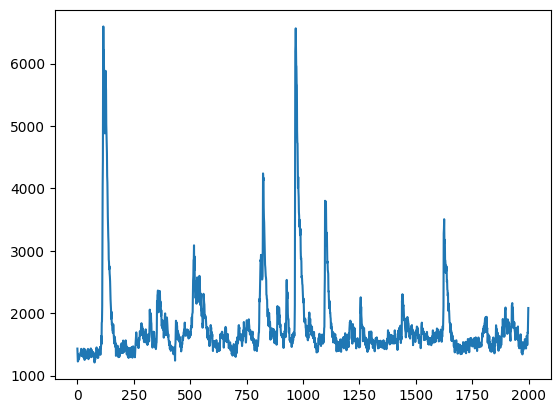

In [49]:
median_trace = np.median(traces2, axis=1)
plt.plot(median_trace)

Plot median cell activity from `trace3`.

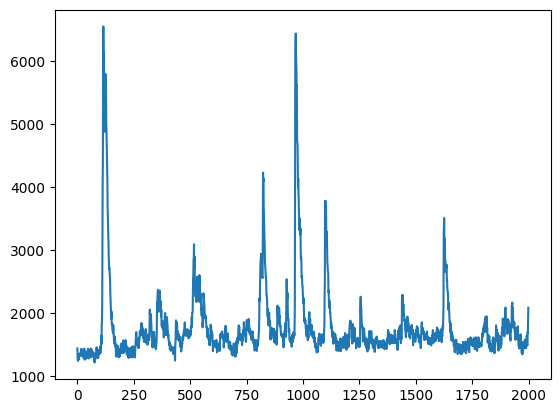

In [50]:
median_trace = np.median(traces3, axis=1)
plt.plot(median_trace)

## **Using Weighted and Robust Aggregation Methods**  

While averaging is often sufficient, not all pixels in the ROI may contribute equally to the signal. Some may be on the edge, poorly illuminated, or contain more noise. Weighted aggregation methods can improve the quality of the final trace by accounting for pixel-level differences. In this section, we introduce weighted averaging using `numpy` to compute a single representative fluorescence trace by taking a weighted average of multiple pixel traces, where the weights are proportional to the average brightness of each pixel. This is done by

- Compute the average fluorescence intensity over time for each pixel trace.
- Use these average values to determine weights and normalize them.
- Apply the weights to combine all pixel traces into a single weighted-average trace, where more active pixels contribute more strongly.

**Example** What is mean fluorescence value of first active pixel of `trace3` over all frames?

In [70]:
np.mean(traces3[:, 0])

1529.894

What is mean fluorescence value of the sixteenth active pixel of `trace3` over all frames?

In [71]:
np.mean(traces3[:, 15])

2130.5095

What is mean fluorescence value of the last active pixel of `trace3` over all frames?

In [72]:
np.mean(traces3[:, -1])

1764.174

Instead of doing this one by one, we can usix `axis` to compute mean values of all active pixels.

**Example** Mean values of all pixels of `trace1`

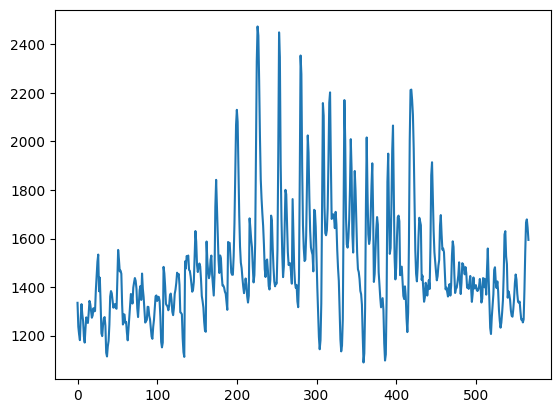

In [61]:
means1 = np.mean(traces1, axis=0)
plt.plot(means1)

Mean values of all pixels of `trace2`

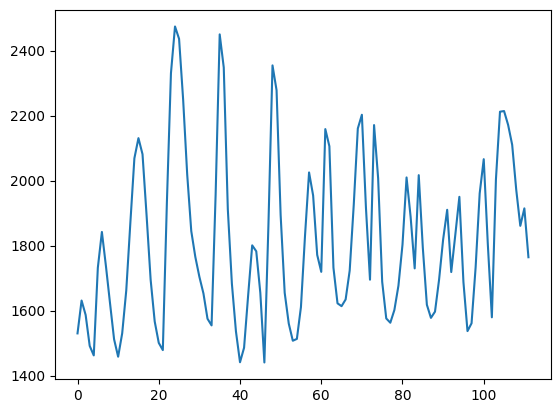

In [62]:
means2 = np.mean(traces2, axis=0)
plt.plot(means2)

Mean values of all pixels of `trace3`

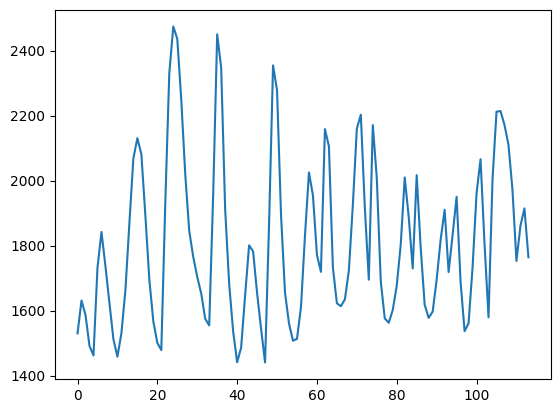

In [63]:
means3 = np.mean(traces3, axis=0)
plt.plot(means3)

**Example** Compute weights of all active pixels for `traces1`. 

In [76]:
means1 = np.mean(traces1, axis=0)
weights1 = means1 / np.sum(means1)

Compute weights of all active pixels for `traces2`.

In [65]:
means2 = np.mean(traces2, axis=0)
weights2 = means2 / np.sum(means2)

Compute weights of all active pixels for `traces3`.

In [66]:
means3 = np.mean(traces3, axis=0)
weights3 = means3 / np.sum(means3)

**Exercise** Apply weights and plot weighted `trace1`.

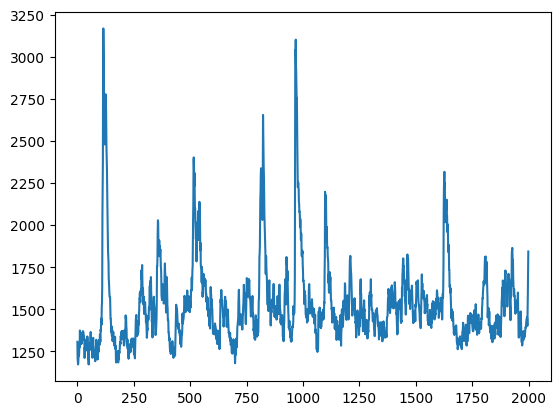

In [67]:
weighted_trace1 = np.average(traces1, axis=1, weights=weights1)
plt.plot(weighted_trace1)

Apply weights and plot weighted `trace2`.

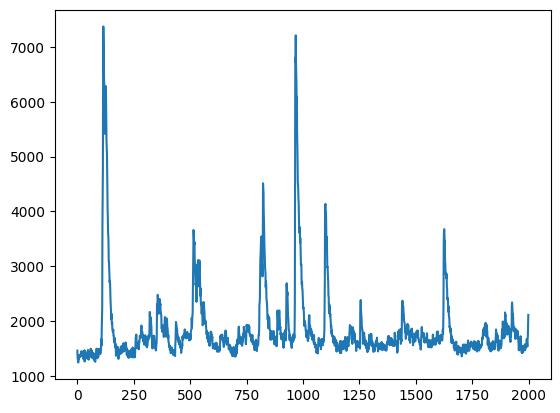

In [68]:
weighted_trace2 = np.average(traces2, axis=1, weights=weights2)
plt.plot(weighted_trace2)

Apply weights and plot weighted `trace3`.

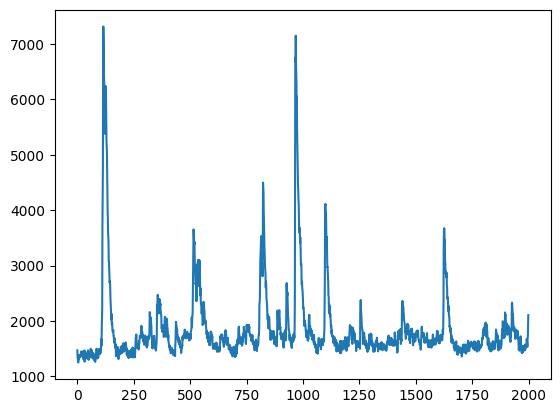

In [69]:
weighted_trace3 = np.average(traces3, axis=1, weights=weights3)
plt.plot(weighted_trace3)